# Hyperparamter Tuning with SageMaker TensorFlow Container

This tutorial focuses on how to create a convolutional neural network model to train the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using **SageMaker TensorFlow container**. It leverages hyperparameter tuning to kick off multiple training jobs with different hyperparameter combinations, to find the one with best model training result.



### This notebook was tested with conda_tensorflow_p36 kernel

![HPO-1](notebook_images/HPO-1.png)

![HPO-2](notebook_images/HPO-2.png)

![HPO-3](notebook_images/HPO-3.png)

![HPO-4](notebook_images/HPO-4.png)

![HPO-5](notebook_images/HPO-5.png)

![HPO-6](notebook_images/HPO-6.png)

## Set Up the Environment 
Set up a few things before starting the workflow:

1. A boto session object to manage interactions with the Amazon SageMaker APIs. 
2. An execution role which will be passed to SageMaker for accessing your AWS resources

In [83]:
!pip install sagemaker==2.59.8

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [84]:
import sagemaker
print(f"sagemaker: {sagemaker.__version__}")

sagemaker: 2.59.8


In [85]:
import os
import json

import logging
import boto3
from botocore.exceptions import ClientError

import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()
role

'arn:aws:iam::328296961357:role/service-role/AmazonSageMaker-ExecutionRole-20191125T182032'

In [86]:
bucket = sess.default_bucket()
bucket

'sagemaker-us-west-2-328296961357'

In [87]:
#run time measurement. Can be removed
from datetime import datetime, timedelta, timezone
import time
tic=time.time()

## Set Up a Tensorflow Training Job
A TensorFlow training job is defined by using the `TensorFlow` estimator class. It lets you run your training script on SageMaker infrastructure in a containerized environment. For more information on how to instantiate it, checkout [this example on setting up a basic training job](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_train.html#TensorFlow-Estimator).

In [88]:
est = TensorFlow(
    entry_point="train.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="2.3.1",
    model_dir="/opt/ml/model",
    py_version="py37",
    instance_type="ml.m5.4xlarge",
    instance_count=1,
    volume_size=250,
    hyperparameters={
        "batch-size": 512,
#        "epochs": 4,
        "epochs": 1,        
    },
)

## Set Up Channels for Training and Testing Data
Upload the MNIST data to the default bucket of your AWS account and pass the S3 URI as the channels of training and testing data for the `TensorFlow` estimator class. For more information about how to set up channels for input data, checkout [this example on setting up a basic training job](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_train.html#Set-up-channels-for-training-and-testing-data).

In [89]:
local_data_dir = "data"
prefix = "mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path=local_data_dir, bucket=bucket, key_prefix=prefix)

channels = {"training": loc, "testing": loc}

## Set Up a Hyperparameter Tuning Job
Now that you have set up the training job and the input data channels, you are ready to train the model with hyperparameter search.

You will set up the hyperparameter tuning job with the following steps:
* Define the ranges of hyperparameters we plan to tune, in this example, we are tuning learning rate
* Define the objective metric for the tuning job to optimize
* Create a hyperparameter tuner with above setting, as well as tuning resource configurations 




For a typical ML model, there are three kinds of hyperparamters:

- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

Learning rate is a continuous variable, therefore, we define its range
by `ContinuousParameter`.

In [90]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparamter_range = {"learning-rate": ContinuousParameter(1e-4, 1e-3)}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits average loss value and we will use it as the objective metric, we also set the `objective_type` to be `Minimize`, so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting.

In [91]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": "average test loss",
        # checkout line 161 in code/train.py
        "Regex": "Test Loss: ([0-9\\.]+)",
    }
]

Now, you'll create a `HyperparameterTuner` object. It takes the following parameters:
- The `TensorFlow` estimator you previously created
- Your hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [92]:
%%time
tuner = HyperparameterTuner(
    est,
    objective_metric_name,
    hyperparamter_range,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

tuner.fit(inputs=channels)

...............................................!
CPU times: user 329 ms, sys: 34.8 ms, total: 364 ms
Wall time: 3min 57s


In [93]:
# display HyperParameter Optimization job name for future analysis and reference.
job_name = tuner.latest_tuning_job.name
job_name

'tensorflow-training-220303-0257'

In [94]:
#store hyperparameter tuning job name to be passed on to the HPO_Analyze_TuningJob_Results.ipynb notebook
%store job_name

Stored 'job_name' (str)


In [95]:
toc=time.time()
elapsed_time = toc-tic
print(elapsed_time)
str(timedelta(seconds=elapsed_time))

238.45028281211853


'0:03:58.450283'

## We have completed Hyper-Paramter Optimizaiton job
We are going to stop notebook execution here. Optionally, you can continue execution of the cells below, deploy and evaluate the model. 
You can view the results of your tuning job in SageMaker console or in SageMaker Studio. 

You can also launch the notebook called HPO_Analyze_TuningJob_Results.ipynb that uses simple python tools to analyze and visualizee the results of your Hyper-Parameter Optimization job.

In [96]:
raise SystemExit("Stop right there!")

## Deploy the Best Model
After training with hyperparameter optimization, you can deploy the best performing model (by the objective metric you defined) to a SageMaker endpoint. For more information about deploying a model to a SageMaker endpoint, check out [this example on deploying a TensorFlow model](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_deploy.html).

In [97]:
instance_id = ! curl http://169.254.169.254/latest/meta-data/instance-id

In [98]:
from datetime import datetime, timedelta, timezone
endpoint_name = f"hpo-{instance_id[-1]}-{datetime.utcnow():%Y-%m-%d-%H%M}"
print(f"Endpoint name: {endpoint_name}") 

Endpoint name: hpo-i-03d02d4ce6272aa4a-2022-03-03-0301


In [99]:
%%time
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name = endpoint_name)


2022-03-03 03:00:47 Starting - Preparing the instances for training
2022-03-03 03:00:47 Downloading - Downloading input data
2022-03-03 03:00:47 Training - Training image download completed. Training in progress.
2022-03-03 03:00:47 Uploading - Uploading generated training model
2022-03-03 03:00:47 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



----!CPU times: user 125 ms, sys: 4.71 ms, total: 130 ms
Wall time: 2min 1s


## Evaluate
Now, you can evaluate the best performing model by invoking the endpoint with MNIST test set. The test data needs to be readily consumable by the model. So you need to arrange them into the correct shape that can be accepted by a TensorFlow model. Moreover, you need to normalize it so that the pixel values have mean 0 and standard deviation 1, since this is the convention you used to train the model.

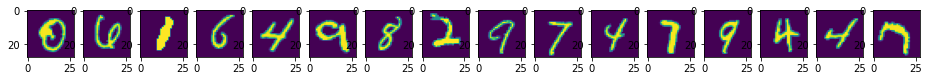

In [100]:
import random
import gzip
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


images_file = "t10k-images-idx3-ubyte.gz"


def read_mnist(data_dir, images_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return images


X = read_mnist(local_data_dir, images_file)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

# preprocess the data to be consumed by the model


def normalize(x, axis):
    eps = np.finfo(float).eps

    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std


samples = normalize(samples, axis=(1, 2))
#samples = np.expand_dims(samples, axis=3)

In [101]:
tf_result = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept="application/json",
    Body=json.dumps({"instances": np.expand_dims(samples, 3).tolist()}),
)

tf_body = tf_result["Body"].read().decode("utf-8")

tf_json_predictions = json.loads(tf_body)["predictions"]

# softmax to logit
tf_predictions = np.array(tf_json_predictions, dtype=np.float32)
tf_predictions = np.argmax(tf_json_predictions, axis=1)

In [102]:
print("Predictions: ", tf_predictions.tolist())

Predictions:  [8, 6, 1, 6, 4, 9, 8, 2, 9, 7, 4, 7, 9, 4, 4, 7]


## (Optional) Clean Up
If you do not plan to use the endpoint, you should delete it to free up some computation resource.

In [103]:
predictor.delete_endpoint()

In [104]:
toc=time.time()
elapsed_time = toc-tic
print(elapsed_time)
str(timedelta(seconds=elapsed_time))

361.7749619483948


'0:06:01.774962'